In [1]:
import os 
import numpy as np
import pandas as pd 
import datetime
import matplotlib.pyplot as plt
from datetime import timedelta

In [2]:
data_type = 'AF' # pilih 'Normal' untuk normal dan 'AF' untuk atrial fibrilliation

folder_dataset = "dataset/data pasien/" 

filenames = []
for folder in os.listdir(folder_dataset):
    files = os.listdir(folder_dataset + folder)
    files = [file for file in files if file.find(".csv") > -1]
    filenames.extend(files)

filenames

['AF 1.csv',
 'AF 2.csv',
 'AF 3.csv',
 'AF 4.csv',
 'AF 5.csv',
 'AF 6.csv',
 'AF 7.csv',
 'Normal 1.csv',
 'Normal 2.csv',
 'Normal 3.csv',
 'Normal 4.csv']

In [3]:
filename = filenames[10]

filename

'Normal 4.csv'

In [4]:
# read dataset, skip first row
ECG = pd.read_csv(os.path.join(folder_dataset, filename.replace(".csv", "") ,filename), skiprows = [0], sep=";")

ECG.columns = ['Time', 'ECG1', 'ECG2']

ECG.head()

,Time,ECG1,ECG2
0,17:13:34.677,3400898.0,3389526.0
1,17:13:34.681,3668131.0,3655747.0
2,17:13:34.685,3604746.0,3592544.0
3,17:13:34.689,3396114.0,3384288.0
4,17:13:34.693,3132433.0,3125091.0


In [5]:
# replace not required char in Time_norm Series 
# ECG["Time_norm"] = ECG.Time.apply(lambda x:  "00:0" + x.replace("[", "") \
#                                                       .replace("]", "") \
#                                                       .replace("'", "") \
#                                                       .replace("'",""))

# create Series with dtype Time
ECG["Idx_Time"] = pd.to_datetime(ECG["Time"]) #, errors='coerce', format="%H:%M:%S.%f")

#Set Time as Index
ECG.index = ECG["Idx_Time"]

# delete unused column 
ECG.drop('Idx_Time', axis=1, inplace=True)
# ECG.drop('Time_norm', axis=1, inplace=True)
ECG.drop('Time', axis=1, inplace=True)

In [6]:
# set sampling rate
fs = 25 #Hz

In [7]:
def plot_signal(data, fs, label="ECG sample raw data", y_label="Amplitude"):
    plt.figure(figsize=(20, 10))
    
    try :
        data = data.values
    except :
        data = np.array(data)
    
    # Calculate time values in seconds
    times = np.arange(data.shape[0], dtype='float') / fs

    plt.subplot(2, 1, 1)
    plt.plot(times, data[:, 0])
    plt.ylabel(y_label)
    plt.xlabel("Time (s)")
    plt.title(label + " - Channel 1")
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.plot(times, data[:, 1])
    plt.ylabel(y_label)
    plt.xlabel("Time (s)")
    plt.title(label + " - Channel 2")
    plt.grid(True)
    
    plt.show()

In [8]:
ECG.tail()

,ECG1,ECG2
Idx_Time,,
2020-12-14 17:21:25.008,-338.0,-1005.0
2020-12-14 17:21:25.012,-416.0,-1085.0
2020-12-14 17:21:25.016,-359.0,-1192.0
2020-12-14 17:21:25.020,-266.0,-1221.0
2020-12-14 17:21:25.024,-325.0,-1112.0


In [9]:
str(ECG.index.min().time()), str(ECG.index.max().time())

('17:13:34.677000', '17:21:25.024000')

17:13:34.677000 17:13:50.677000


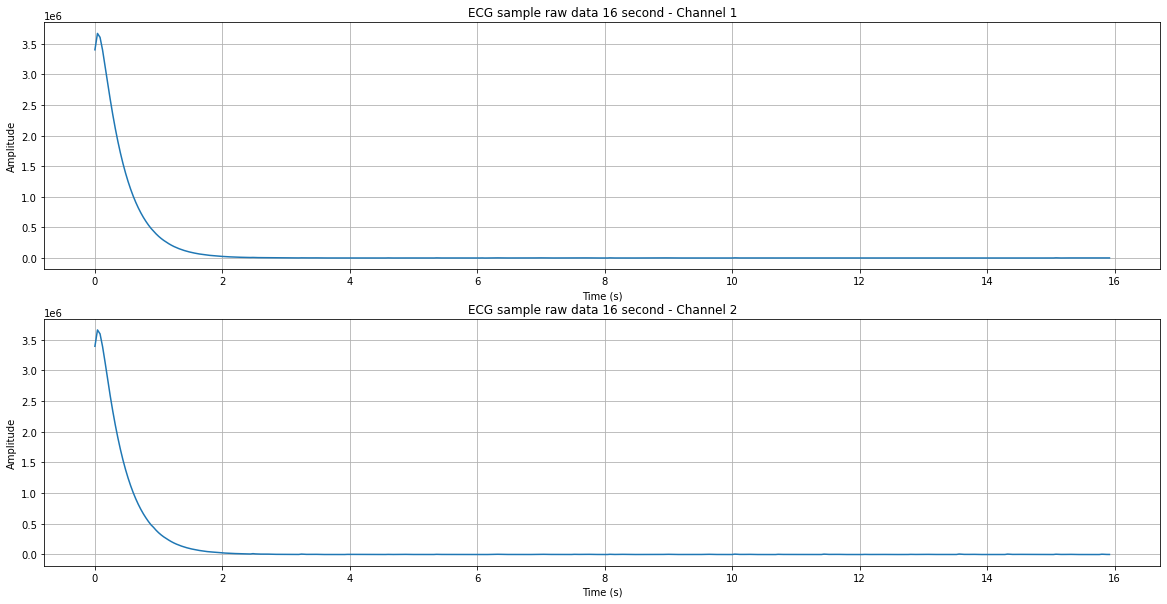

In [10]:
start = ECG.index[0].time()
end = (ECG.index[0] + datetime.timedelta(seconds=16)).time()
print(start, end)

plot_signal(ECG.between_time(start, end), fs, "ECG sample raw data 16 second")

17:14:06.677000 17:14:22.677000


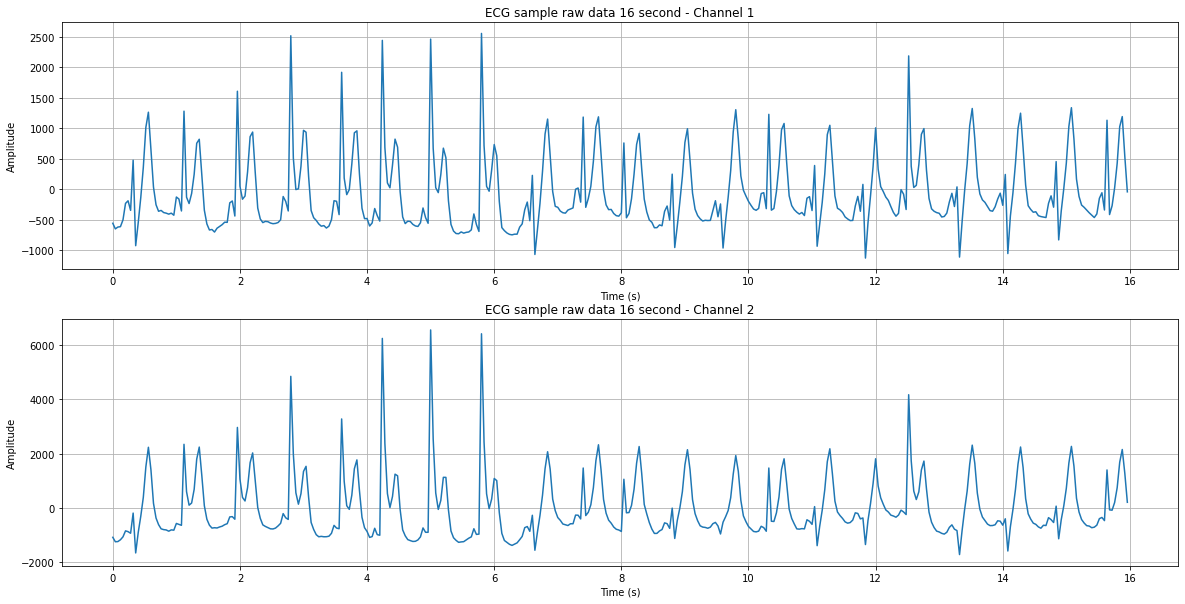

In [11]:
start = (ECG.index[0] + datetime.timedelta(seconds=32)).time()
end = (ECG.index[0] + datetime.timedelta(seconds=48)).time()
print(start, end)

plot_signal(ECG.between_time(start, end), fs, "ECG sample raw data 16 second")

___
## Baseline Wander Removal
### Asymmetric Least Squares Smoothing

In [12]:
from scipy.signal import argrelextrema

In [13]:
from scipy.signal import find_peaks 

In [14]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

In [15]:
def plot_16s_sample(original, als, baseline, label="Plot 16 s sample"):
    times = np.arange(len(original[0]), dtype='float') / fs
    
    plt.figure(figsize=(20, 15))
    
    plt.subplot(3,1,1)
    plt.plot(times, original[0])
    plt.plot(times, baseline[0])
    plt.legend(['original signal - Channel 1', 'baseline'])
    plt.title(label)
    plt.grid(True)
    
    plt.subplot(3,1,2)
    plt.plot(times, original[1])
    plt.plot(times, baseline[1])
    plt.legend(['original signal - Channel 2', 'baseline'])
    plt.title(label)
    plt.grid(True)
    
    plt.subplot(3,1,3)
    plt.plot(times, als[0])
    plt.plot(times, als[1])
    plt.legend(['signal als - Channel 1', 'signal als - Channel 2'])
    plt.grid(True)
    
    plt.show()

In [16]:
def baseline_als(y, lam=10000, p=0.05, n_iter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    w = np.ones(L)
    for i in range(n_iter):
        W = sparse.spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

- apply to all sample signal

In [17]:
ECG.index.min(), ECG.index.max()

(Timestamp('2020-12-14 17:13:34.677000'),
 Timestamp('2020-12-14 17:21:25.024000'))

In [18]:
def perdelta(start, end, delta):
    curr = start
    while curr < end:
        yield curr
        curr += delta
        
time_interval = [time_result for time_result in perdelta(ECG.index.min(), ECG.index.max(), timedelta(seconds=16))]

In [19]:
ECG_ALS = []
BASELINE_ALS = []
ORI = []
for time_intv in list(zip(time_interval, time_interval[1:])):
    X = ECG.between_time(time_intv[0].time(), time_intv[1].time())
        
    ecg1 = X['ECG1'].values
    ecg2 = X['ECG2'].values

    if len(ecg1) > 0 and len(ecg2) > 0:
        baseline1 = baseline_als(ecg1)
        ALS1 = ecg1 - baseline1
        
        baseline2 = baseline_als(ecg2)
        ALS2 = ecg2 - baseline2

        ORI.append(np.array([ecg1, ecg2]))
        ECG_ALS.append(np.array([ALS1, ALS2]))
        BASELINE_ALS.append(np.array([baseline1, baseline2]))

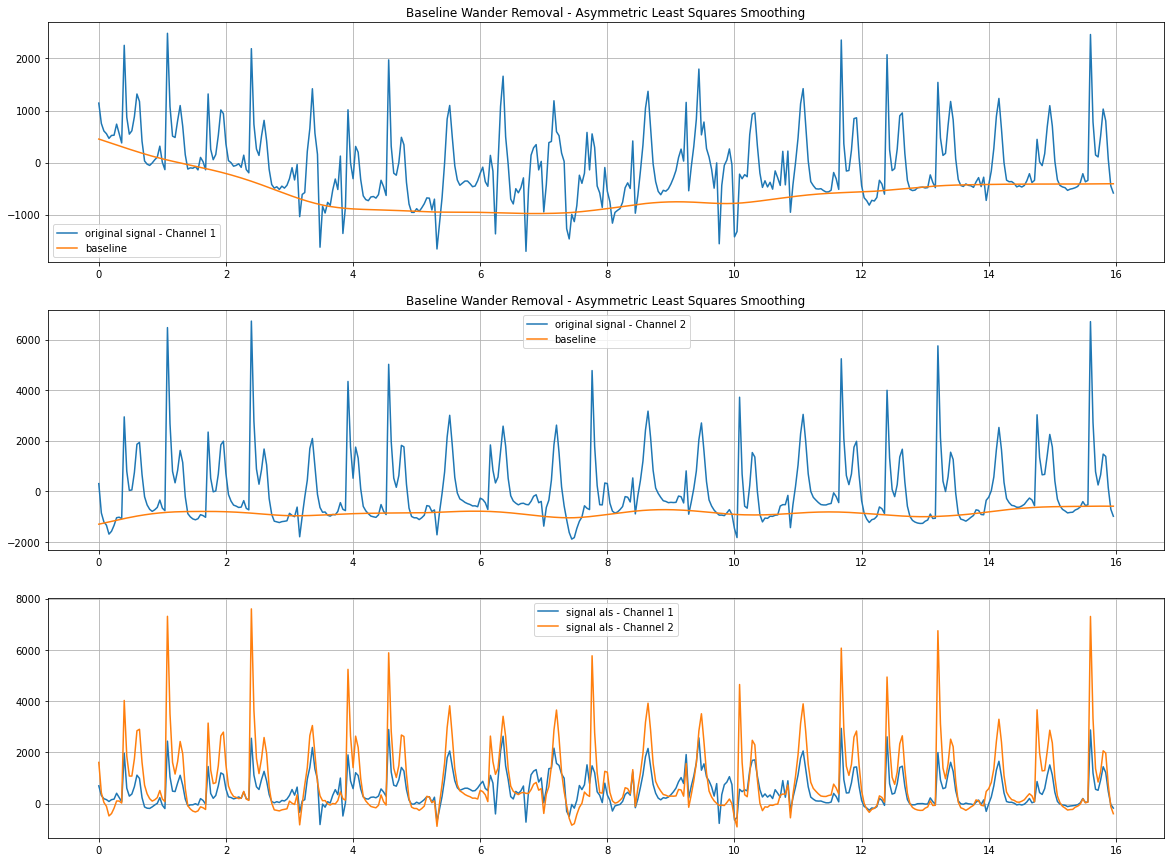

In [39]:
plot_16s_sample(ORI[1], ECG_ALS[1], BASELINE_ALS[1], label="Baseline Wander Removal - Asymmetric Least Squares Smoothing")

___
## Signal Normalization

In [21]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler


In [22]:
scaler = MaxAbsScaler()
ECG_Norm = []

for als in ECG_ALS :
    als1 = np.expand_dims(als[0], 1)
    als2 = np.expand_dims(als[1], 1)
    
    scaler.fit(als1)
    
    als_norm1 = scaler.transform(als1)
    als_norm2 = scaler.transform(als2)
    
    ECG_Norm.append([als_norm1, als_norm2])

In [23]:
def plot_normalized_signal(data, fs, label="ECG sample raw data", y_label="Normalized Value"):
    plt.figure(figsize=(20, 5))
    
    # Calculate time values in seconds
    times = np.arange(data[0].shape[0], dtype='float') / fs

    plt.plot(times, data[0])
    plt.plot(times, data[1])
    plt.ylabel(y_label)
    plt.xlabel("Time (s)")
    plt.title(label + " - Channel 1")
    plt.legend(['channel 1', 'channel 2'])
    plt.grid(True)
    plt.show()

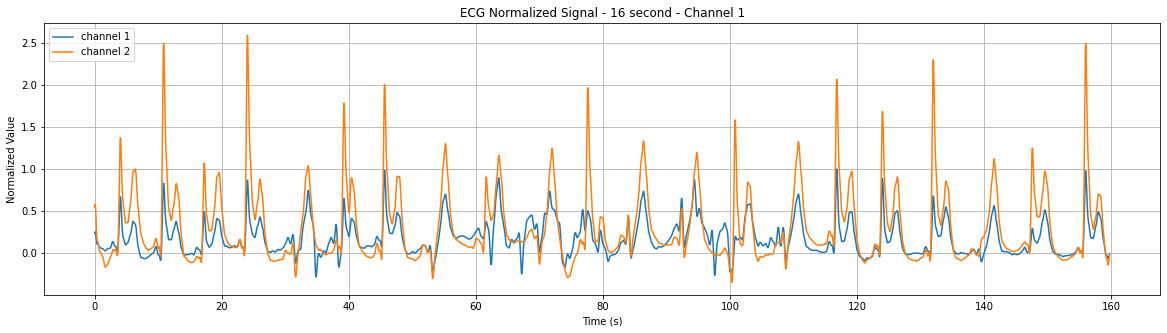

In [40]:
plot_normalized_signal(ECG_Norm[1], fs, "ECG Normalized Signal - 16 second")

____

## Upsampling to 250Hz

In [25]:
from scipy.signal import resample, resample_poly

In [26]:
def upsampling_twice(data):
    # upsampling interpolation
    result = np.zeros(2*len(data)-1)
    result[0::2] = data
    result[1::2] = (data[1:] + data[:-1]) / 2
    return result

In [27]:
new_fs = 250 #Hz

ECG_250Hz = []
for data in ECG_Norm:
    data[0] = upsampling_twice(data[0][:,0]) 
    data[0] = resample_poly(data[0], new_fs, int(new_fs/5))
    
    data[1] = upsampling_twice(data[1][:,0]) 
    data[1] = resample_poly(data[1], new_fs, int(new_fs/5))
    
    ECG_250Hz.append(data)
    

___

## QRS Detection

pip package : `pip install py-ecg-detectors`

In [28]:
from ecgdetectors import Detectors
detectors = Detectors(new_fs)

In [29]:
def plot_r_peaks(r_peaks, data, fs, label = "Detected R peaks"):
    times = np.arange(data.shape[0], dtype='float') / fs

    ymin = np.min(data)
    ymax = np.max(data)
    alpha = 0.2 * (ymax - ymin)
    ymax += alpha
    ymin -= alpha

    plt.figure(figsize=(20, 5))
    plt.plot(times, data)
    
    plt.vlines([r / fs for r in r_peaks], ymin, ymax,
               color="r",
               linewidth=2)

    plt.title(label)
    plt.grid(True)
    plt.show()

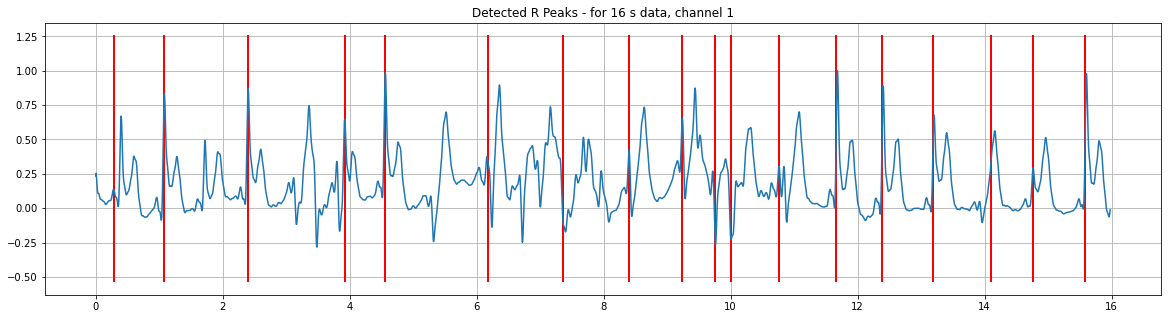

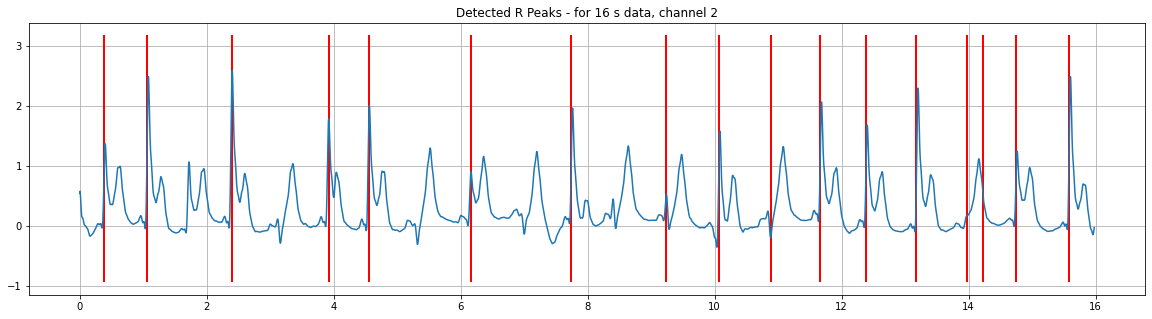

In [41]:
idx = 1

data = np.array(ECG_250Hz[idx])

for ch in range(0,2):
    r_peaks = detectors.christov_detector(data[ch])
    plot_r_peaks(r_peaks, data[ch], new_fs, label="Detected R Peaks - for 16 s data, channel %d" % (ch + 1))

## generate R - R interval for al signal

In [31]:
ECG_split = []
for i in range(len(ECG_250Hz)) :
    data = np.array(ECG_250Hz[i])
    if len(data) > 0:
        r_peaks = []
        try :
            r_peaks = detectors.christov_detector(data[0])
        except :
            print("cannot find R peaks in ALS Norm, idx %d" % i)
        RRs = np.diff(r_peaks)
        RRs_med = np.median(RRs)
        if not np.isnan(RRs_med) and RRs_med > 0:
            for rp in r_peaks :
                split1 = data[0][rp : rp + int(RRs_med * 1.2)] 
                split2 = data[1][rp : rp + int(RRs_med * 1.2)] 
                
                n1 = len(split1) if len(split1) <= 300 else 300
                n2 = len(split2) if len(split2) <= 300 else 300
                pad1 = np.zeros(300)
                pad2 = np.copy(pad1)
                pad1[0:n1] = split1[0:n1]
                pad2[0:n2] = split2[0:n2]
                ECG_split.append([pad1, pad2])


In [32]:
def plot_1_sample(data, fs):
    times = np.arange(data.shape[0]) / fs * 1000 

    plt.plot(times, data)
    plt.title("Plot 1 sample")
    plt.xlabel("Time (ms)")
    plt.ylabel("Normalized Value")
    plt.grid(True)
    plt.show()

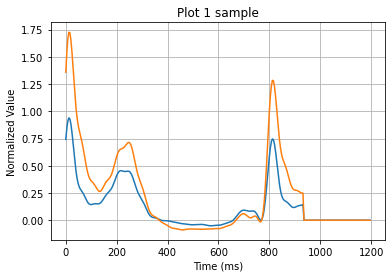

In [62]:
idx = 74
data = np.array(list(zip(ECG_split[idx][0], ECG_split[idx][1])))
plot_1_sample(data, new_fs)

In [34]:
data = []
for i in range(len(ECG_split)):
    x = list(ECG_split[i][0])
    x.extend(list(ECG_split[i][1]))
    data.append(x)

In [35]:
ECG_DF = pd.DataFrame(data)

In [36]:
ECG_DF.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,0.476018,0.467686,0.459251,0.449990,0.440969,0.432248,0.423832,0.415696,0.407229,0.399350,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.006214,0.006147,0.006084,0.006025,0.005968,0.005911,0.005845,0.005782,0.005721,0.005663,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000231,0.000213,0.000197,0.000182,0.000166,0.000150,0.000132,0.000115,0.000098,0.000081,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.000304,-0.000300,-0.000293,-0.000285,-0.000278,-0.000271,-0.000267,-0.000265,-0.000266,-0.000269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.000909,-0.000861,-0.000812,-0.000767,-0.000730,-0.000700,-0.000676,-0.000655,-0.000632,-0.000608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
ECG_DF.to_csv("dataset/AFDB_pasien_%s" % (filename), index=False, header=False)

In [38]:
filename

'Normal 4.csv'